In [1]:
import os
import sys
sys.path.append(f"{os.environ['HOME']}/Project/af2rave/")

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import af2rave

matplotlib.rcParams.update({"text.usetex": True, 
                            "font.family": "sans-serif",
                            "figure.dpi": 300,
                            "legend.frameon": False})


## Feature selection with rMSA results

This notebook ranks the pairwise distances as potential features according to their coefficient of variance. 

The first step is to read in the PDB files and initialize an instance.

In [2]:
pdb_dir = f"./datasets/DDR1_MSA8"
ref_pdb = f"{pdb_dir}/pred_1.pdb"
pdb_files = [f"{pdb_dir}/{file}" for file in os.listdir(pdb_dir) if file.endswith('.pdb')]

rMSA = af2rave.features.rMSAAnalysis(pdb_files, ref_pdb)

### Drop unphysical structures

Then we compute the RMSD of each structure compared to the highest pLDDT structure. We set a cutoff of 10 Angstrom. This can be adjusted by the user on different occasions.

If the structure has very flexible ends (terminals), the RMSD distribution will be long-tailed and largely depends on the conformation of these flexible ends. It is recommended that these tails be removed in AF2 calculations.

<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
/var/folders/2m/cb06ylm133g8xftjqc2ffl580000gp/T/ipykernel_38687/1167380135.py:7: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel("C$^\\alpha$ RMSD ($\mathrm \AA$)")


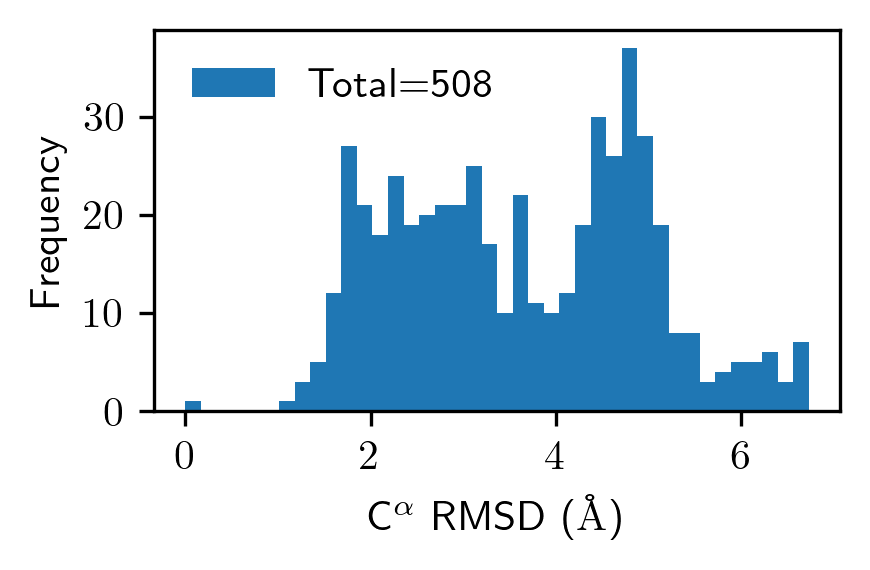

In [3]:
rmsd_cutoff = 7 # Angstrom

rmsd = rMSA.drop_unphysical_structures(selection="name CA", rmsd_cutoff=rmsd_cutoff)

fig, ax = plt.subplots(figsize=(3, 2), tight_layout=True)
_ = ax.hist(rmsd, bins=40, label=f"Total={rmsd.shape[0]}")
ax.set_xlabel("C$^\\alpha$ RMSD ($\\mathrm \AA$)")
ax.set_ylabel("Frequency")
ax.set_xlim()
ax.legend()

### Compute and rank pairwise distances

Next, we choose a subset of atoms and use them to construct pairwise distances. These distances will be ranked according to their coefficient of variance and the top `n_features` will be selected as a feature. This is a very crude selection, so feel free to include more. 

The choice of `atom_set` can be all CA atoms, but here is where your prior knowledge about the particular system may help. If you know good features or important atoms, include them in the list.

The plot will be a histogram of the CoVs for the pairwise distance between all these selected atoms and the cutoff.

(508, 5151)


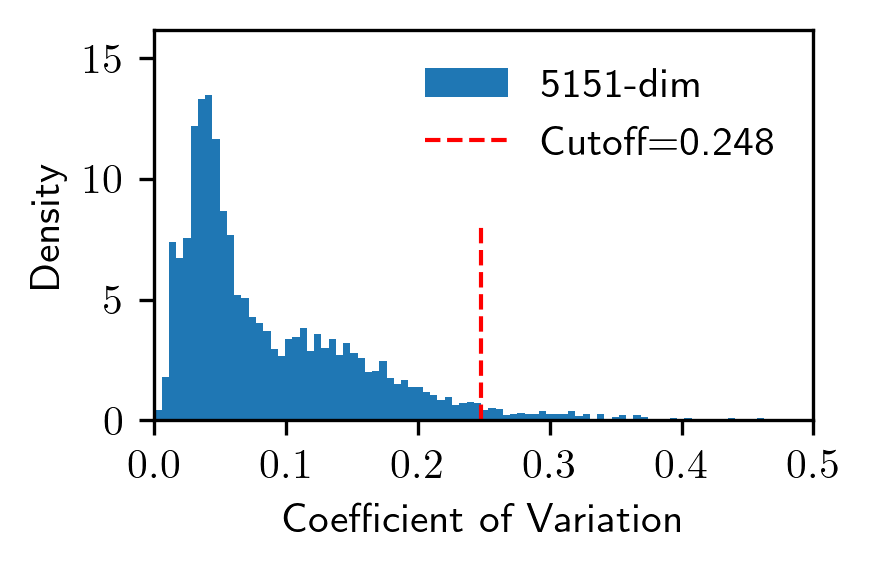

In [4]:
n_features = 200
atom_set = ["resid 52 to 81 and name CA",
            "resid 162 to 224 and name CA",
            "resid 185 and name CB CG",    # DFG-Asp
            "resid 186 and name CZ CG",    # DFG-Phe
            "resid 187 and name O",        # DFG-Gly
            "resid 73 and name CD",        # ChelE
            "resid 56 and name CB CZ NZ",  # SB-K
            "resid 171 and name N"         # SB-R
            ]      

selection = " or ".join([f"({atom})" for atom in atom_set])
feature, names, cv = rMSA.rank_features(selection=selection)

fig, ax = plt.subplots(figsize=(3, 2), tight_layout=True)

counts, _, _ = ax.hist(cv, bins=100, label=f"{len(names)}-dim", density=True)
cv_cutoff = cv[n_features]
ax.vlines(cv_cutoff, 0, np.max(counts)*0.6, color="red", linestyle="--", linewidth=1, label=f"Cutoff={cv_cutoff:.3f}")

ax.set_ylim(0, np.max(counts)*1.2)
ax.set_xlabel("Coefficient of Variation")
ax.set_ylabel("Density")
ax.set_xlim(0, 0.5)
ax.legend()

In [5]:
print(rMSA.get_chimera_plotscript(names[:n_features]))

open ./datasets/DDR1_MSA8/pred_1.pdb
distance :164@CA :192@CA
distance :163@CA :192@CA
distance :163@CA :193@CA
distance :164@CA :191@CA
distance :164@CA :193@CA
distance :193@CA :223@CA
distance :165@CA :192@CA
distance :193@CA :222@CA
distance :165@CA :190@CA
distance :165@CA :191@CA
distance :163@CA :194@CA
distance :164@CA :190@CA
distance :165@CA :193@CA
distance :193@CA :221@CA
distance :198@CA :206@CA
distance :163@CA :191@CA
distance :198@CA :208@CA
distance :195@CA :221@CA
distance :199@CA :206@CA
distance :192@CA :223@CA
distance :196@CA :221@CA
distance :163@CA :195@CA
distance :166@CA :190@CA
distance :194@CA :221@CA
distance :192@CA :222@CA
distance :193@CA :224@CA
distance :164@CA :194@CA
distance :198@CA :207@CA
distance :198@CA :221@CA
distance :197@CA :208@CA
distance :196@CA :220@CA
distance :81@CA :187@CZ
show :187 a
distance :201@CA :220@CA
distance :77@CA :192@CA
distance :200@CA :220@CA
distance :194@CA :222@CA
distance :194@CA :223@CA
distance :195@CA :220@CA
dis

In [6]:
reduced_atom_pairs = rMSA.reduce_features(names[:n_features], 20, bins=50, kde_bandwidth=0.02)
print(rMSA.get_chimera_plotscript(reduced_atom_pairs))

open ./datasets/DDR1_MSA8/pred_1.pdb
distance :74@CA :189@CA
distance :172@CA :194@CA
distance :193@CA :216@CA
distance :78@CA :187@CZ
show :187 a
distance :81@CA :187@CZ
show :187 a
distance :199@CA :209@CA



In [7]:
# Configuations for PCA
pca, pca_result = rMSA.pca(n_components=10)

12 clusters identified.


Text(0, 0.5, 'PC2')

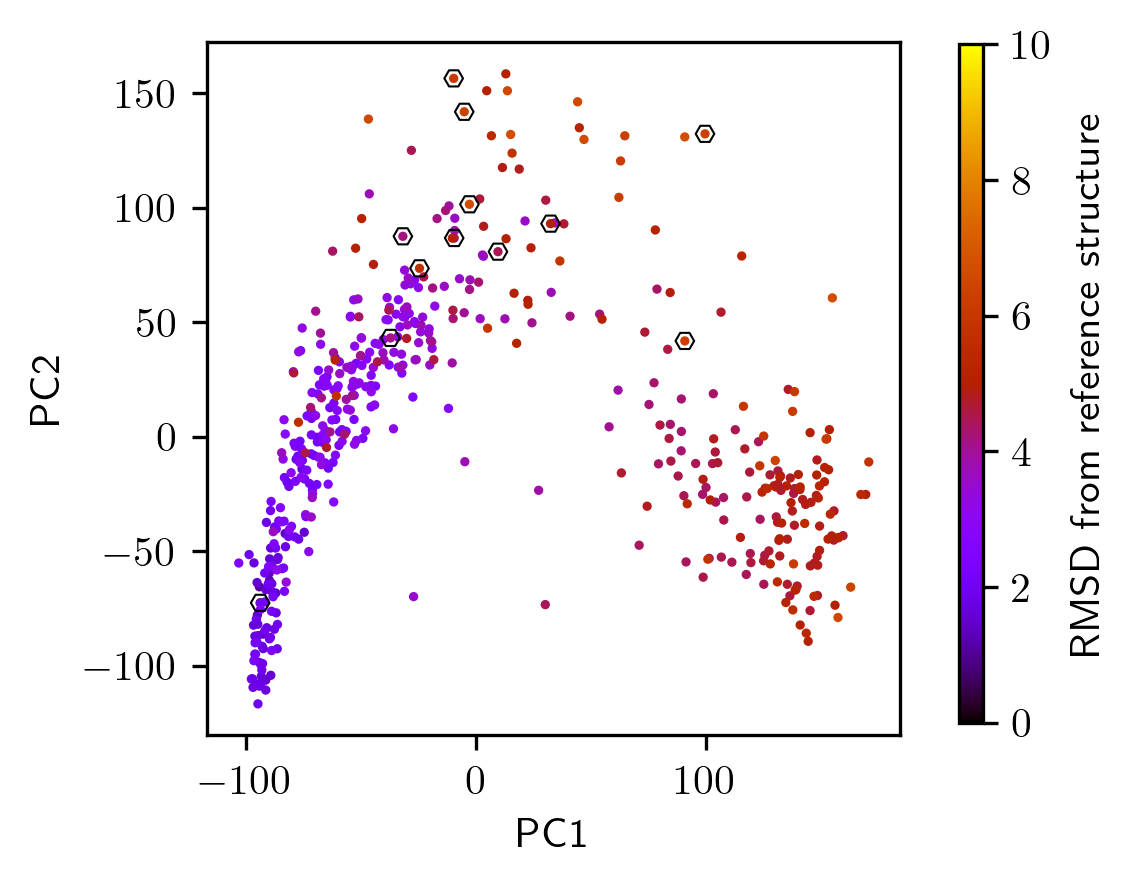

In [8]:
center_list, center_id = rMSA.regular_space_clustering(names[:n_features], 5.0, max_centers=100, batch_size=100, randomseed=0)
print(f"{center_list.shape[0]} clusters identified.")

# Plotting 
fig, ax = plt.subplots(figsize=(4,3), dpi=300)
ax.set_box_aspect(1)

scatter_kwargs = {"s": 5, 
                  "c": rmsd, 
                  "cmap": "gnuplot", 
                  "norm": "linear", 
                  "edgecolors": "none",
                  "vmin": 0.0,
                  "vmax": 10.0}

cbar = ax.scatter(pca_result[:,0], pca_result[:,1], **scatter_kwargs)
cb_ax = fig.add_axes([.85,.124,.02,.754])
fig.colorbar(cbar, orientation='vertical', cax=cb_ax)
cb_ax.set_ylabel("RMSD from reference structure", loc="center")

# cluster center in PC space
pca_cc = pca.transform(rMSA.feature_array[center_id])

cc_kwargs = {"s": 20, 
             "edgecolor": "black",
             "marker": "H",
             "facecolor": "None", 
             "linewidth": 0.5}
ax.scatter(pca_cc[:,0], pca_cc[:,1], **cc_kwargs)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

pred_1.pdb
pred_408.pdb
pred_422.pdb
pred_433.pdb
pred_416.pdb
pred_452.pdb
pred_441.pdb
pred_478.pdb
pred_600.pdb
pred_466.pdb
pred_550.pdb
pred_570.pdb


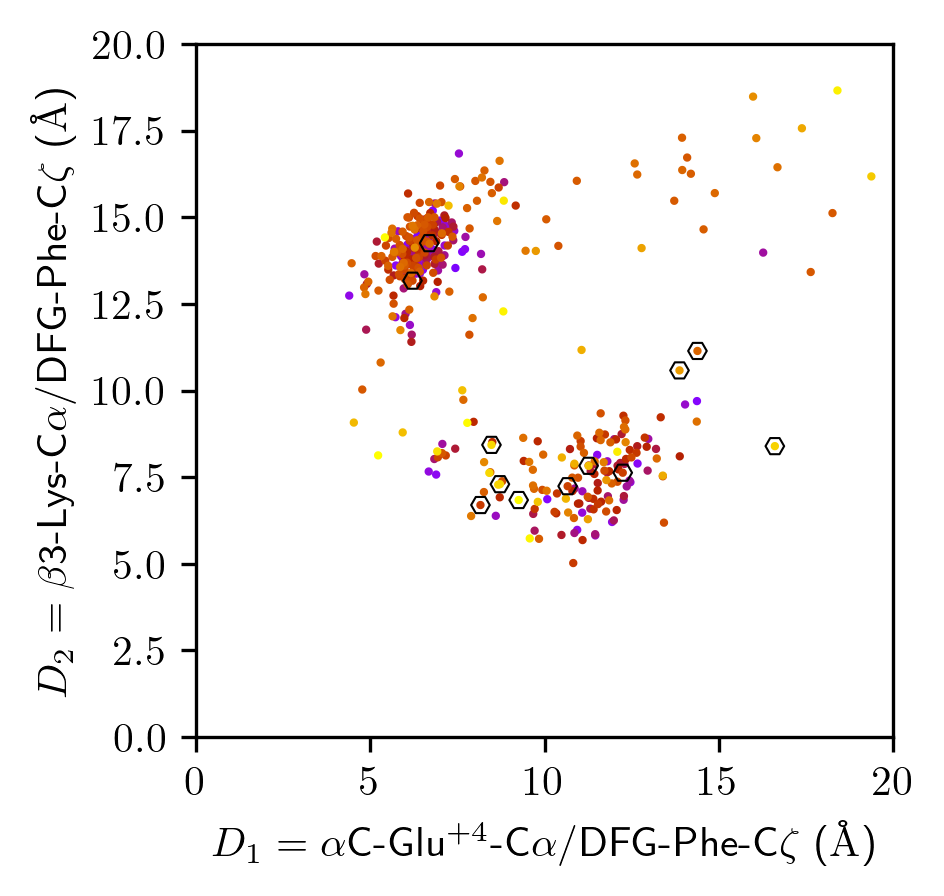

In [9]:
tag_dfg_phe_cz = rMSA.traj.top.select("resid 186 and name CZ")[0]
tag_ac_glu4_ca = rMSA.traj.top.select("resid 77 and name CA")[0]
tag_k_cons_ca = rMSA.traj.top.select("resid 56 and name CA")[0]

d1 = rMSA.features["MET78-CA_PHE187-CZ"].ts
d2 = rMSA.features["LYS57-CA_PHE187-CZ"].ts

fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(d1, d2, s=1, c=rmsd, cmap="gnuplot")
ax.scatter(d1[center_id], d2[center_id], **cc_kwargs)

ax.set_xlim(0, 20)
ax.set_ylim(0, 20)
ax.set_xlabel(r"$D_1 = \alpha$C-Glu$^{+4}$-C$\alpha$/DFG-Phe-C$\zeta$ ($\mathrm \AA$)")
ax.set_ylabel(r"$D_2 = \beta$3-Lys-C$\alpha$/DFG-Phe-C$\zeta$ ($\mathrm \AA$)")

starting_structures = [rMSA.pdb_name[i].split("/")[-1] for i in center_id]
for s in starting_structures:
    print(s)

(0.0, 1.0)

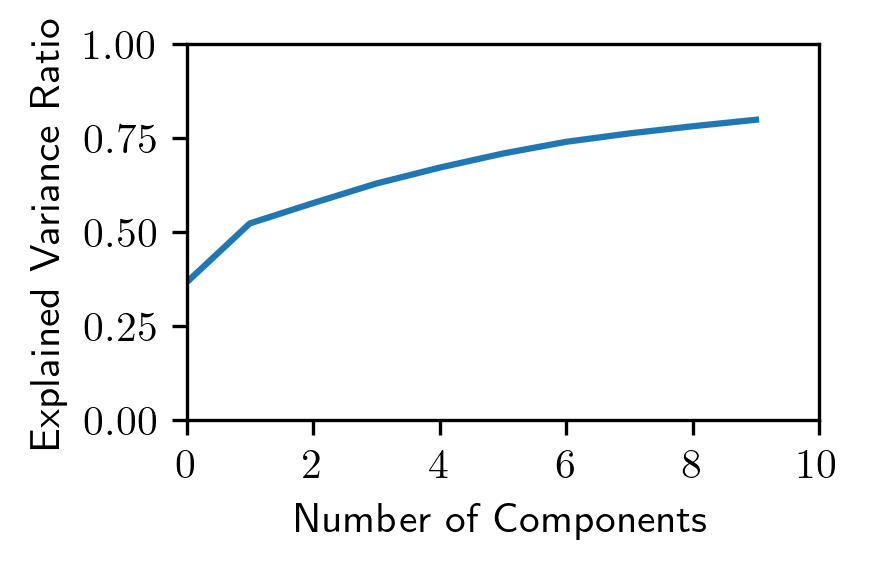

In [10]:
fig, ax = plt.subplots(figsize=(3,2), dpi=300, tight_layout=True)
ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.set_xlabel("Number of Components")
ax.set_ylabel("Explained Variance Ratio")
ax.set_xlim(0, 10)
ax.set_ylim(0, 1)